<a href="https://colab.research.google.com/github/aman-18-choudhary/Time-Series-Forecasting-data-sci-project/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [3]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

df.columns = ['Passengers']
df.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


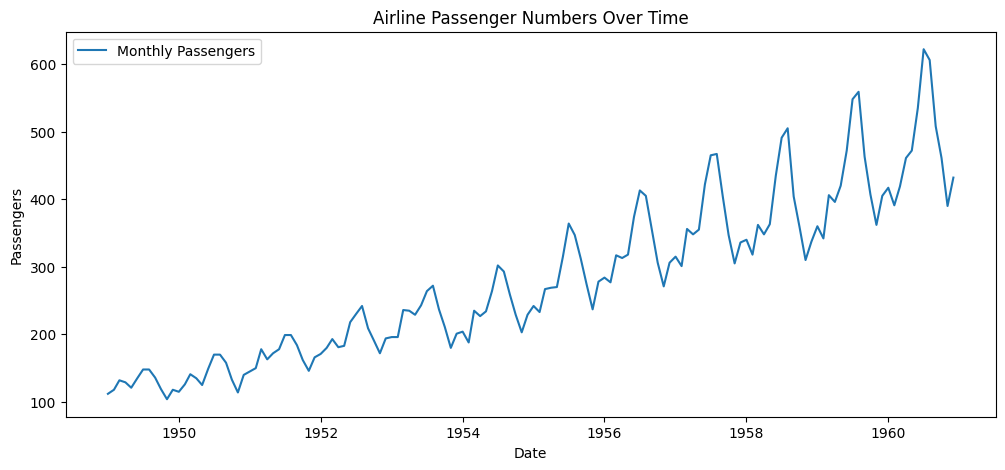

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df, label='Monthly Passengers')
plt.title("Airline Passenger Numbers Over Time")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


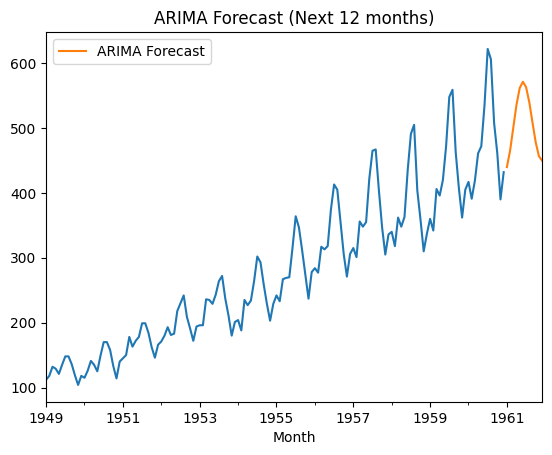

In [5]:
model_arima = ARIMA(df, order=(2, 1, 2))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=12)

df['Passengers'].plot(label='Actual')
forecast_arima.plot(label='ARIMA Forecast', legend=True)
plt.title("ARIMA Forecast (Next 12 months)")
plt.show()


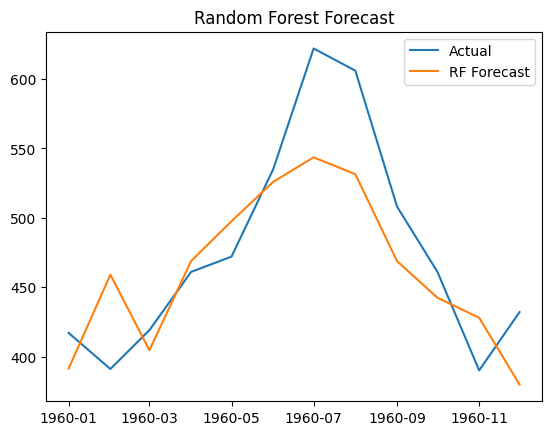

In [6]:
# Prepare features
df_ml = df.copy()
df_ml['Month'] = df_ml.index.month
df_ml['Year'] = df_ml.index.year
df_ml['Lag1'] = df_ml['Passengers'].shift(1)
df_ml.dropna(inplace=True)

# Split
train = df_ml[:-12]
test = df_ml[-12:]

features = ['Month', 'Year', 'Lag1']
target = 'Passengers'

rf = RandomForestRegressor(n_estimators=100)
rf.fit(train[features], train[target])
rf_preds = rf.predict(test[features])

# Plot
plt.plot(test.index, test['Passengers'], label='Actual')
plt.plot(test.index, rf_preds, label='RF Forecast')
plt.legend()
plt.title("Random Forest Forecast")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


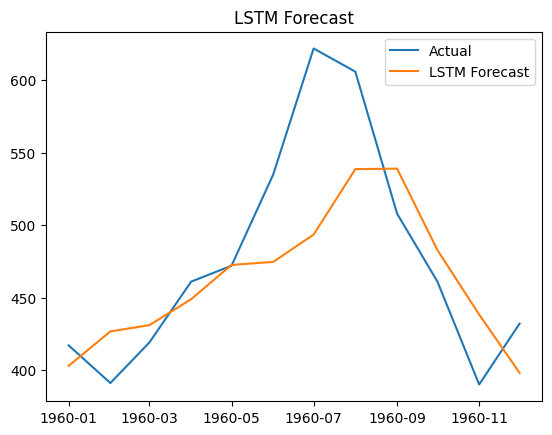

In [7]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Train/test split
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

# Predict
lstm_preds = model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds)

# Plot
actual = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(df.index[-12:], actual, label='Actual')
plt.plot(df.index[-12:], lstm_preds, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast")
plt.show()


In [8]:
print("RMSE (ARIMA):", np.sqrt(mean_squared_error(df['Passengers'][-12:], forecast_arima)))
print("RMSE (Random Forest):", np.sqrt(mean_squared_error(test['Passengers'], rf_preds)))
print("RMSE (LSTM):", np.sqrt(mean_squared_error(actual, lstm_preds)))


RMSE (ARIMA): 58.190769595489655
RMSE (Random Forest): 44.77040949853672
RMSE (LSTM): 51.131991694072774
